In [114]:
import numpy as np
import gpjax as gpx
import os
import jax
import matplotlib.pyplot as plt
import jax.random as jr

from dataclasses import dataclass, field

import jax.numpy as jnp
from jaxtyping import Float
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from gpjax.base import param_field, static_field
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.typing import (
    Array,
    ScalarFloat,
)
from jaxtyping import (
    Float,
    Num,
)

import cola
from cola.ops import (
    Dense,
    Diagonal,
    LinearOperator,
)

from gpjax.distributions import GaussianDistribution

from beartype.typing import Callable, Any
from jaxtyping import Int

import sys
import os
abs_path = os.path.abspath('../src')
sys.path.append(abs_path)
from p53_data import JAXP53_Data, dataset_3d, generate_test_times
from kernels import latent_kernel
from custom_gps import p53_posterior
from plotter import plot_gp

jax.config.update('jax_enable_x64', True)

from matplotlib import rcParams

plt.style.use("https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle")

# Check if LaTeX is in notebook path
if os.environ.get('PATH') is not None:
    if 'TeX' not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'

colors = rcParams["axes.prop_cycle"].by_key()["color"]

import tensorflow_probability.substrates.jax.bijectors as tfb

key = jr.PRNGKey(42)

from gpjax.base import meta_leaves

from gpjax.kernels.computations import (
    AbstractKernelComputation,
    DenseKernelComputation,
)

In [115]:
p53_data = JAXP53_Data(replicate=0, data_dir='../data')
training_times, gene_expressions, variances = dataset_3d(p53_data)

dataset_train = gpx.Dataset(training_times, gene_expressions)

testing_times = generate_test_times()

def optimise_mll(posterior, dataset, NIters=1000, key=key):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    print(f'MLL before opt: {objective(posterior, dataset):.3f}')
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=objective,
        train_data=dataset,
    )
    return opt_posterior, history

# Shared params

In [116]:
@dataclass
class model_params(gpx.base.Module):
    # Sensitivities of the genes
    initial_sensitivities = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64)

    true_s: Float[Array, "1 5"] = param_field(
        initial_sensitivities,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_sensitivities"},
        trainable=True,
    )

    # Degradation rates of the genes
    initial_decays = jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64)

    true_d: Float[Array, "1 5"] = param_field(
        initial_decays,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_degradations"},
        trainable=True,
    )

    # Sigmoid to map real numbers to (0,1) and then scales and shifts to get(0.5, 3.5) # NOTE: tfb.Chain acts Right to Left
    l_bijector = tfb.Chain(
        [
            tfb.Shift(jnp.array(0.5, dtype=jnp.float64)),
            tfb.Scale(jnp.array(3.0, dtype=jnp.float64)),
            tfb.Sigmoid(),
        ]
    )

    initial_lengthscale = jnp.array(2.5, dtype=jnp.float64)

    lengthscale: Float[Array, " O"] = param_field(
        initial_lengthscale, bijector=l_bijector, metadata={"name": "lengthscale"}
    )
    
    initial_constrained_b = jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64)
    
    true_b: Float[Array, "1 5"] = param_field(initial_constrained_b, bijector=tfb.Softplus(), metadata={"name": " basal_rates"}, trainable=True)

In [117]:
@dataclass
class shared_mean(gpx.mean_functions.AbstractMeanFunction, model_params):
    #shared_params: model_params
    shared_params: model_params = field(default_factory=model_params)

    def __call__(self, x: Float[Array, "N D"]) -> Float[Array, "N O"]:
        num_genes = 5

        decays = self.shared_params.true_d
        
        block_size = (x.shape[0] // num_genes)
        # Define the mean function
        #mean = (self.true_b / self.true_d).reshape(1, -1)
        mean = (self.shared_params.true_b / decays).reshape(1, -1)
        mean = mean.repeat(block_size, jnp.newaxis).reshape(-1,1)

        return mean
        
        
        #return jnp.ones((x.shape[0], 1)) * 0


In [118]:
@dataclass
class shared_kernel(gpx.kernels.AbstractKernel, model_params):
    
    #shared_params: model_params = static_field(None)
    shared_params: model_params = field(default_factory=model_params)

    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:

        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = (
            kxx_switch * self.kernel_xx(t, t_prime)
            + kff_switch * self.kernel_ff(t, t_prime)
            + kxf_switch * self.kernel_xf(t, t_prime)
            + kxf_t_switch * self.kernel_xf(t, t_prime).T
        )

        return final_kernel
    """
    # Required to correctly register with JAX PyTree
    def tree_flatten(self):
        children = (self.shared_params.true_s, self.shared_params.true_d, self.shared_params.lengthscale, self.shared_params.true_b)
        aux_data = {}
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        true_s, true_d, lengthscale, true_b = children
        shared_params = model_params(true_s=true_s, true_d=true_d, lengthscale=lengthscale, true_b=true_b)
        return cls(shared_params)
    """
    
    def kernel_xx(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.shared_params.true_s[j] * self.shared_params.true_s[k] * self.shared_params.lengthscale * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term
        
        return kxx.squeeze()
    
    def kernel_xf(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = gene_xpr - latent_force

        first_term = 0.5 * self.shared_params.lengthscale * jnp.sqrt(jnp.pi) * self.shared_params.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.shared_params.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.shared_params.lengthscale) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.shared_params.lengthscale + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        
        return kxf.squeeze()
    
    def kernel_ff(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
            
        t = t[0].reshape(-1)
        t_prime = t_prime[0].reshape(-1)

        sq_dist = jnp.square(t.reshape(-1, 1) - t_prime)
        sq_dist = jnp.divide(sq_dist, 2 * self.shared_params.lengthscale.reshape((-1, 1)))

        K = jnp.exp(-sq_dist)

        return K.squeeze() 
    
    # Helper functions
    def h(self, j: Float[Array, " O"], k: Float[Array, " O"], t1: Float[Array, " O"], t2: Float[Array, " O"]) -> ScalarFloat:

        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.shared_params.true_d[j] + self.shared_params.true_d[k])

        first_multiplier = jnp.exp(-self.shared_params.true_d[k] * t_dist)
        
        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.shared_params.lengthscale) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.shared_params.lengthscale + self.gamma(k))

        second_multiplier = jnp.exp(-(self.shared_params.true_d[k] * t2 + self.shared_params.true_d[j] * t1))
        
        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.shared_params.lengthscale) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        #print(f"result: {result}")
        return result

    def gamma(self, k: Float[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.shared_params.true_d[k] * self.shared_params.lengthscale) / 2
    



In [119]:
shared_params = model_params()
mean_shared = shared_mean(shared_params)
kernel_shared = shared_kernel(shared_params)

In [120]:
prior_shared = gpx.gps.Prior(mean_function=mean_shared, kernel=kernel_shared, jitter=1e-4)
likelihood_shared = gpx.likelihoods.Gaussian(num_datapoints=dataset_train.n, obs_stddev=jnp.array([1.0e-3], dtype=jnp.float64))

posterior_shared = prior_shared * likelihood_shared

In [121]:
len(meta_leaves(prior_shared))

22

In [122]:
len(jax.tree_util.tree_leaves(kernel_shared))

11

In [123]:
len(jax.tree_util.tree_leaves(mean_shared))

11

In [124]:
objective = gpx.objectives.ConjugateMLL(negative=True)
print(f'MLL before opt: {objective(posterior_shared, dataset_train):.3f}')

MLL before opt: 34385.197


In [125]:
opt_posterior_shared, history_shared = optimise_mll(posterior_shared, dataset_train)

MLL before opt: 34385.197
Optimization terminated successfully.
         Current function value: 4.615128
         Iterations: 259
         Function evaluations: 284
         Gradient evaluations: 284


In [126]:
p53_post_shared = p53_posterior(prior=opt_posterior_shared.prior, likelihood=opt_posterior_shared.likelihood)

latent_dist_shared = p53_post_shared.latent_predict(testing_times, p53_data)
predictive_dist_shared = p53_post_shared.likelihood(latent_dist_shared)

predictive_mean_shared = predictive_dist_shared.mean()
predictive_std_shared = predictive_dist_shared.stddev()

f = p53_data.f_observed.squeeze()

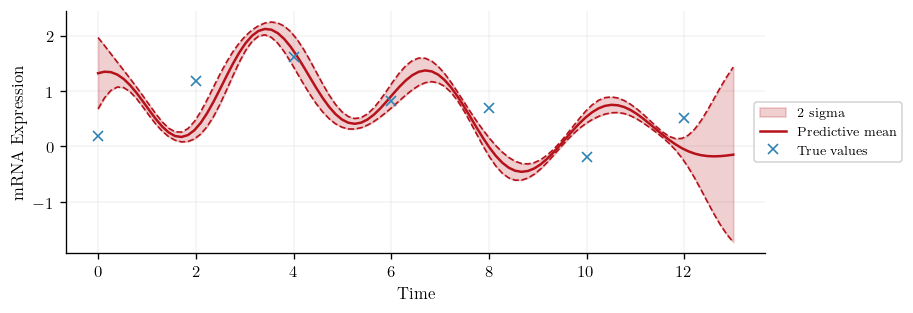

In [127]:
plot_gp(testing_times, latent_dist_shared, y_scatter=f)

In [128]:
meta_leaves(opt_posterior_shared)

[({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array([0.14486783], dtype=float64)),
 ({'name': 'lengthscale',
   'bijector': <tfp.bijectors.Chain 'chain_of_shift_of_scale_of_sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64 bijectors=[<tfp.bijectors.Shift 'shift' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64>, <tfp.bijectors.Scale 'scale' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64>, <tfp.bijectors.Sigmoid 'sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]>,
   'trainable': True,
   'pytree_node': True},
  Array(2.5, dtype=float64)),
 ({'name': 'lengthscale',
   'bijector': <tfp.bijectors.Chain 'chain_of_shift_of_scale_of_sigmoid' batch_

### Sharing parameters from the kernel to the mean

In [129]:
# Define custom mean
@dataclass
class latent_mean(gpx.mean_functions.AbstractMeanFunction):
    r"""
    Simple Input Motif mean function

    ```math
        f(x_{j}) = \frac{B_{j}}{D_{j}} 
    ```

    From equation 2 in paper.

    $B_{j}$ represents the basal rate for gene $j$ and is a trainable paramater.
    """

    # Pass kernel instance that contains true_d parameter
    kernel: gpx.kernels.AbstractKernel = field(default_factory=lambda: latent_kernel())
    
    #true_d: Float[Array, "1 5"] = static_field(jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64))
    
    # Define parameters
    initial_constrained_b = jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64)
    
    true_b: Float[Array, "1 5"] = param_field(initial_constrained_b, bijector=tfb.Softplus(), metadata={"name": " basal_rates"}, trainable=True,)

    def __call__(self, x: Float[Array, "N D"]) -> Float[Array, "N O"]:
        r"""Evaluate the mean function at the given points.

        Args:
            x (Float[Array, " D"]): The point at which to evaluate the mean function.

        Returns
        -------
            Float[Array, "1"]: The evaluated mean function.
        """
        # BUG: Concretization error if this is used ?
        #num_genes = len(jnp.unique(x[:, 1]))
        num_genes = 5

        decays = self.kernel.true_d
        
        block_size = (x.shape[0] // num_genes)
        # Define the mean function
        #mean = (self.true_b / self.true_d).reshape(1, -1)
        mean = (self.true_b / decays).reshape(1, -1)
        mean = mean.repeat(block_size, jnp.newaxis).reshape(-1,1)

        return mean

In [130]:
mean_func = latent_mean()
kernel_func = latent_kernel()

In [131]:
# Function definitions
def initialise_gp(kernel, mean, dataset):
    prior = gpx.gps.Prior(mean_function=mean, kernel=kernel, jitter=1e-4)
    likelihood = gpx.likelihoods.Gaussian(
        num_datapoints=dataset.n, obs_stddev=jnp.array([1.0e-3], dtype=jnp.float64)
    )
    posterior = prior * likelihood
    return posterior

In [132]:
posterior_k2m = initialise_gp(kernel_func, mean_func, dataset_train)
opt_posterior_k2m, history_k2m = optimise_mll(posterior_k2m, dataset_train)

MLL before opt: 34385.197
Optimization terminated successfully.
         Current function value: 4.615128
         Iterations: 270
         Function evaluations: 310
         Gradient evaluations: 310


In [133]:
meta_leaves(opt_posterior_k2m)

[({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array([0.14486782], dtype=float64)),
 ({'name': 'lengthscale',
   'bijector': <tfp.bijectors.Chain 'chain_of_shift_of_scale_of_sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64 bijectors=[<tfp.bijectors.Shift 'shift' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64>, <tfp.bijectors.Scale 'scale' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64>, <tfp.bijectors.Sigmoid 'sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]>,
   'trainable': True,
   'pytree_node': True},
  Array(1.33019449, dtype=float64)),
 ({'name': ' kxx_degradations',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] f

In [111]:
from gpjax.base import meta_map

# This is how constrain works!
def _apply_constrain(meta_leaf):
    meta, leaf = meta_leaf

    if meta is None:
        return leaf

    return meta.get("bijector", tfb.Identity()).forward(leaf)


res = meta_map(_apply_constrain, opt_posterior_k2m)
print(res)

ConjugatePosterior(prior=Prior(kernel=latent_kernel(compute_engine=DenseKernelComputation(), active_dims=None, name='p53 kernel', true_s=Array([1.23112968, 1.29312768, 1.27391646, 3.04455644, 1.28951438],      dtype=float64), true_d=Array([0.84807374, 0.88443912, 0.87453132, 2.08663214, 0.87959801],      dtype=float64), l=Array(2.87261841, dtype=float64)), mean_function=latent_mean(kernel=latent_kernel(compute_engine=DenseKernelComputation(), active_dims=None, name='p53 kernel', true_s=Array([1.31326169, 1.31326169, 1.31326169, 1.31326169, 1.31326169],      dtype=float64), true_d=Array([0.69315885, 0.69314719, 6.84151473, 0.69314718, 0.69314718],      dtype=float64), l=Array(3.27242546, dtype=float64)), true_b=Array([0.69315086, 0.69314718, 0.92377079, 0.69314718, 0.69314718],      dtype=float64)), jitter=0.0001), likelihood=Gaussian(num_datapoints=35, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.76820214], dtype=float64)), jitter=1e-06)


In [113]:
kernel_func.constrain()

latent_kernel(compute_engine=DenseKernelComputation(), active_dims=None, name='p53 kernel', true_s=Array([1.31326169, 1.31326169, 1.31326169, 1.31326169, 1.31326169],      dtype=float64), true_d=Array([0.91301525, 0.91301525, 0.91301525, 0.91301525, 0.91301525],      dtype=float64), l=Array(3.27242546, dtype=float64))

## Mean to kernel param sharing

In [135]:
@dataclass
class latent_mean2(gpx.mean_functions.AbstractMeanFunction):

    # Sensitivities of the genes
    initial_sensitivities = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64)

    true_s: Float[Array, "1 5"] = param_field(
        initial_sensitivities,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_sensitivities"},
        trainable=True,
    )

    # Degradation rates of the genes
    initial_decays = jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64)

    true_d: Float[Array, "1 5"] = param_field(
        initial_decays,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_degradations"},
        trainable=True,
    )

    # Sigmoid to map real numbers to (0,1) and then scales and shifts to get(0.5, 3.5) # NOTE: tfb.Chain acts Right to Left
    l_bijector = tfb.Chain(
        [
            tfb.Shift(jnp.array(0.5, dtype=jnp.float64)),
            tfb.Scale(jnp.array(3.0, dtype=jnp.float64)),
            tfb.Sigmoid(),
        ]
    )

    initial_lengthscale = jnp.array(2.5, dtype=jnp.float64)

    l: Float[Array, " O"] = param_field(
        initial_lengthscale, bijector=l_bijector, metadata={"name": "lengthscale"}
    )

    initial_constrained_b = jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64)
    
    true_b: Float[Array, "1 5"] = param_field(initial_constrained_b, bijector=tfb.Softplus(), metadata={"name": " basal_rates"}, trainable=True,)

    def __call__(self, x: Float[Array, "N D"]) -> Float[Array, "N O"]:
        r"""Evaluate the mean function at the given points.

        Args:
            x (Float[Array, " D"]): The point at which to evaluate the mean function.

        Returns
        -------
            Float[Array, "1"]: The evaluated mean function.
        """
        # BUG: Concretization error if this is used ?
        #num_genes = len(jnp.unique(x[:, 1]))
        num_genes = 5
        
        block_size = (x.shape[0] // num_genes)
        # Define the mean function
        #mean = (self.true_b / self.true_d).reshape(1, -1)
        mean = (self.true_b / self.true_d).reshape(1, -1)
        mean = mean.repeat(block_size, jnp.newaxis).reshape(-1,1)

        return mean


In [140]:
@dataclass
class latent_kernel2(gpx.kernels.AbstractKernel):

    mean: gpx.mean_functions.AbstractMeanFunction = field(default_factory=lambda: latent_mean2())


    def __call__(self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]) -> ScalarFloat:
        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = (
            kxx_switch * self.kernel_xx(t, t_prime)
            + kff_switch * self.kernel_ff(t, t_prime)
            + kxf_switch * self.kernel_xf(t, t_prime)
            + kxf_t_switch * self.kernel_xf(t_prime, t)
        )

        return final_kernel
    
    def kernel_xx(
        self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]
    ) -> ScalarFloat:

        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.mean.true_s[j] * self.mean.true_s[k] * self.mean.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term

        return kxx.squeeze()

    def kernel_xf(
        self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]
    ) -> ScalarFloat:
        
        # Get gene expression and latent force from flag (kxf anf kfx are transposes)
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = gene_xpr - latent_force

        first_term = 0.5 * self.mean.l * jnp.sqrt(jnp.pi) * self.mean.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.mean.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.mean.l) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.mean.l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms

        return kxf.squeeze()

    def kernel_ff(
        self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]
    ) -> ScalarFloat:

        t = t[0].reshape(-1)
        t_prime = t_prime[0].reshape(-1)

        sq_dist = jnp.square(t.reshape(-1, 1) - t_prime)
        sq_dist = jnp.divide(sq_dist, 2 * self.mean.l.reshape((-1, 1)))

        K = jnp.exp(-sq_dist)

        return K.squeeze()

    # Helper functions
    def h(
        self,
        j: Int[Array, " O"],
        k: Int[Array, " O"],
        t1: Int[Array, " O"],
        t2: Int[Array, " O"],
    ) -> ScalarFloat:

        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.mean.true_d[j] + self.mean.true_d[k])

        first_multiplier = jnp.exp(-self.mean.true_d[k] * t_dist)

        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.mean.l) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.mean.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.mean.true_d[k] * t2 + self.mean.true_d[j] * t1))

        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.mean.l) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        return result

    def gamma(self, k: Int[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.mean.true_d[k] * self.mean.l) / 2

In [141]:
posterior_m2k = initialise_gp(latent_kernel2(), latent_mean2(), dataset_train)
opt_posterior_m2k, history_m2k = optimise_mll(posterior_m2k, dataset_train)

MLL before opt: 34385.197
         Current function value: 4.615128
         Iterations: 282
         Function evaluations: 363
         Gradient evaluations: 353


/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [142]:
meta_leaves(opt_posterior_m2k)

[({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array([0.14486783], dtype=float64)),
 ({'name': 'lengthscale',
   'bijector': <tfp.bijectors.Chain 'chain_of_shift_of_scale_of_sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64 bijectors=[<tfp.bijectors.Shift 'shift' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64>, <tfp.bijectors.Scale 'scale' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64>, <tfp.bijectors.Sigmoid 'sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]>,
   'trainable': True,
   'pytree_node': True},
  Array(1.33019492, dtype=float64)),
 ({'name': ' basal_rates',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forwar